
 Sheet2で最もTotal_Killsが高いChampion: Yunara（41 kills）
 1試合で最も多くキルしたChampion: Kaisa
 試合列: HLEvsAL
 キル数: 11

=== ハイライト ===
Most Picked: ['Ksante', 'Ryze', 'Yunara'] => 8
Most Banned: ['Azir'] => 14
Best Win Rate (≥5 games): ['Orianna', 'Wukong'] => 80.0
Worst Win Rate (≥5 games): ['Jarvan'] => 0.0
Most Kills (Sheet2): ['Yunara'] => 41
Most Kills in a Single Game: Kaisa => 11 kills in HLEvsAL

=== チーム別使用チャンピオン ===

 100T が使用したチャンピオン一覧:
   Ambessa: 1 回
   Aurora: 1 回
   Kaisa: 1 回
   Rakan: 1 回
   Rell: 1 回
   Sion: 1 回
   Taliyah: 1 回
   Vi: 1 回
   Xinzhao: 1 回
   Ziggs: 1 回

 AL が使用したチャンピオン一覧:
   Reksai: 2 回
   Cassiopeia: 1 回
   Corki: 1 回
   Neeko: 1 回
   Pantheon: 1 回
   Poppy: 1 回
   Qiyana: 1 回
   Taliyah: 1 回
   Yunara: 1 回

 BLG が使用したチャンピオン一覧:
   Caitlyn: 1 回
   Elise: 1 回
   Jarvan: 1 回
   Reksai: 1 回
   Taliyah: 1 回

 CFO が使用したチャンピオン一覧:
   Ryze: 2 回
   Sion: 2 回
   Alister: 1 回
   Caitlyn: 1 回
   Draven: 1 回
   Neeko: 1 回
   Qiyana: 1 回
   Xinzhao: 1 回

 FLY が使用したチャンピオン一覧:
   Alis

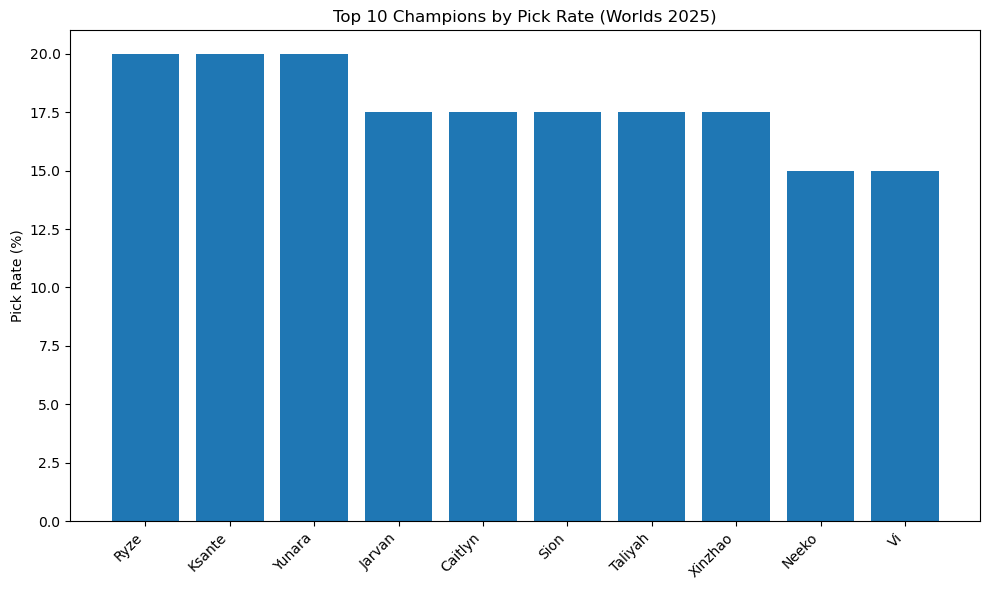

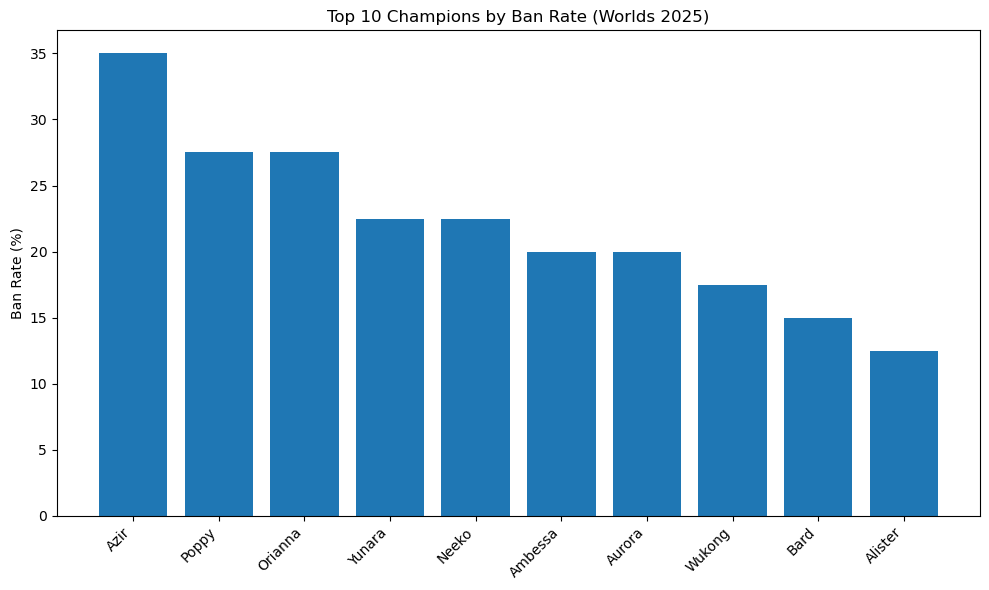


=== グラフ出力: ハイライト詳細 (上位5 / 下位5 / キル系) ===


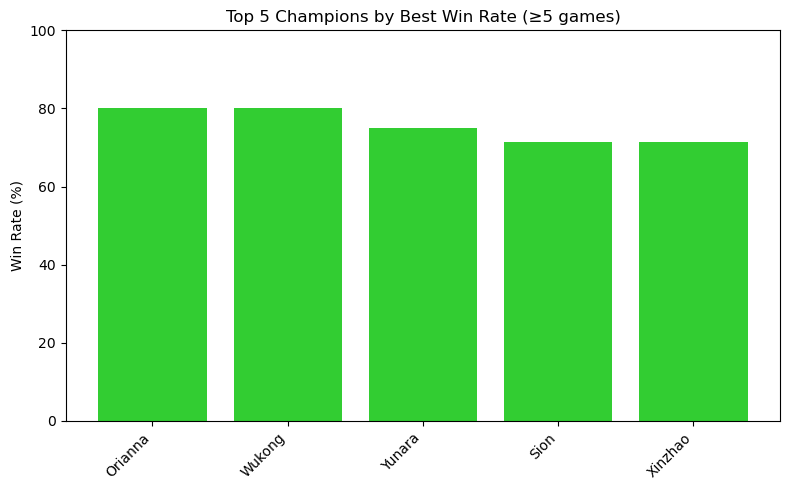

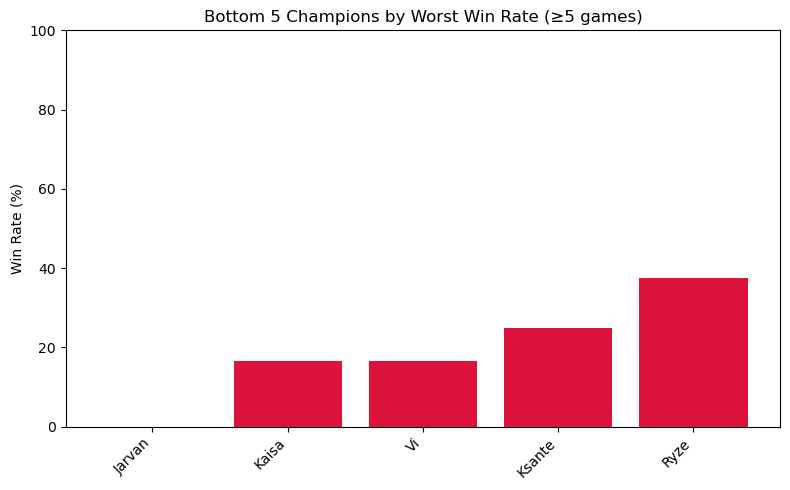

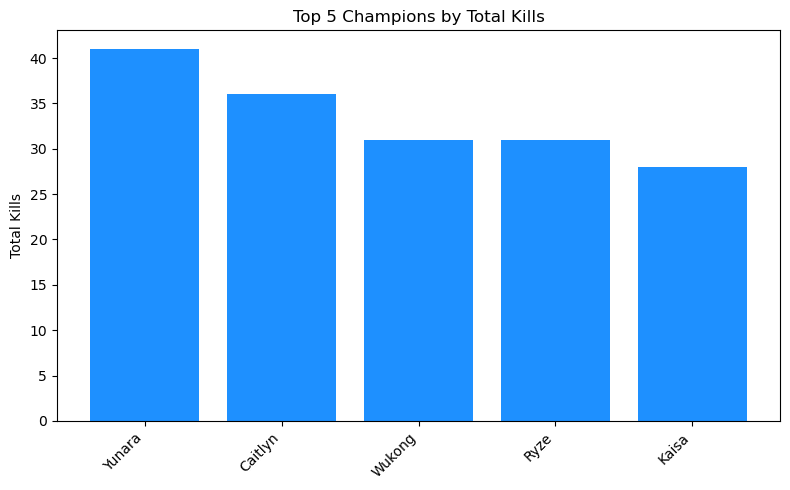


 出力シート一覧:
・Champion_Stats: チャンピオン別統計 (勝率・Pick/Ban率)
・Team_Usage: チーム別使用チャンピオン
・Team_Distinct_Picks: チームごとのユニークPick数
・Champion_Kills_Detail: Sheet2から自動生成された総キル＋平均キル
・Numeric_Cell_Counts: Sheet2内の数値セル数一覧
・Top_Kills_Per_Game: 1試合で最も多くキルしたチャンピオン
・Key_Highlights: ハイライト（最多Pick/Ban・最高/最低勝率・最多キル・1試合最多キル）


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# === 設定 ===
file_path = "worlds2025.xlsx"   # 必要に応じてフルパスへ変更
sheet_name = "Sheet1"

# === データ読み込み ===
df = pd.read_excel(file_path, sheet_name=sheet_name)

# --- データ整形 ---
pick_cols = ["Pick1", "Pick2", "Pick3", "Pick4", "Pick5"]
ban_cols  = ["Ban1",  "Ban2",  "Ban3",  "Ban4",  "Ban5"]

pick_df = df.melt(
    id_vars=["Match ID", "Team", "Win/Lose"],
    value_vars=pick_cols,
    var_name="PickSlot",
    value_name="Champion"
).dropna(subset=["Champion"])

pick_df["Champion"] = pick_df["Champion"].astype(str).str.strip().str.title()
pick_df["Win/Lose"] = pick_df["Win/Lose"].astype(str).str.strip().str.title()
pick_df["Team"] = pick_df["Team"].astype(str).str.strip()

# 総試合数（チーム単位ではなく試合単位）
total_matches = df["Match ID"].nunique()

# === チャンピオン別統計 ===
champ_stats = pick_df.groupby("Champion").agg(
    Games_Played=("Champion", "count"),
    Wins=("Win/Lose", lambda x: (x == "Win").sum()),
    Losses=("Win/Lose", lambda x: (x == "Lose").sum())
)
champ_stats["Win Rate (%)"] = (champ_stats["Wins"] / champ_stats["Games_Played"] * 100).round(1)

# === Ban集計 ===
ban_df = df.melt(value_vars=ban_cols, value_name="Banned_Champion").dropna()
ban_df["Banned_Champion"] = ban_df["Banned_Champion"].astype(str).str.strip().str.title()
ban_counts = ban_df["Banned_Champion"].value_counts().rename("Times_Banned")

# 結合
result = champ_stats.merge(ban_counts, left_index=True, right_index=True, how="outer").fillna(0)
result["Pick Rate (%)"] = (result["Games_Played"] / (total_matches * 2) * 100).round(1)
result["Ban Rate (%)"]  = (result["Times_Banned"] / (total_matches * 2) * 100).round(1)

# === 追加要件 ===============================
# 1) 最も多くPickされたChampion
max_picks = result["Games_Played"].max() if len(result) else 0
most_picked = result.index[result["Games_Played"] == max_picks].tolist() if max_picks > 0 else []

# 2) 最も多くBanされたChampion
max_bans = result["Times_Banned"].max() if len(result) else 0
most_banned = result.index[result["Times_Banned"] == max_bans].tolist() if max_bans > 0 else []

# 3) 5試合以上プレイされたChampionで最高/最低勝率
threshold = 5
eligible = result[result["Games_Played"] >= threshold].copy()
best_wr_list, worst_wr_list = [], []
if not eligible.empty:
    max_wr = eligible["Win Rate (%)"].max()
    min_wr = eligible["Win Rate (%)"].min()
    best_wr_list  = eligible.index[eligible["Win Rate (%)"] == max_wr].tolist()
    worst_wr_list = eligible.index[eligible["Win Rate (%)"] == min_wr].tolist()

# 4) Sheet2からキル関連情報の集計
top_kill_champions, max_kills = [], 0
avg_kill_df = None
numeric_counts_df = None
top_single_game_df = None

try:
    kills_raw = pd.read_excel(file_path, sheet_name="Sheet2", header=0)
    kills_raw.columns = kills_raw.columns.map(str)

    if "Champion" not in kills_raw.columns:
        kills_raw.rename(columns={kills_raw.columns[0]: "Champion"}, inplace=True)
    if "Total_Kills" not in kills_raw.columns:
        kills_raw.rename(columns={kills_raw.columns[1]: "Total_Kills"}, inplace=True)

    kills_raw["Champion"] = kills_raw["Champion"].astype(str).str.strip().str.title()
    kills_raw["Total_Kills"] = pd.to_numeric(kills_raw["Total_Kills"], errors="coerce").fillna(0)

    game_cols = [c for c in kills_raw.columns if c not in ["Champion", "Total_Kills"]]
    for c in game_cols:
        kills_raw[c] = pd.to_numeric(kills_raw[c], errors="coerce")

    # C列以降から合計を再計算
    kills_raw["Computed_Total_Kills"] = kills_raw[game_cols].sum(axis=1, skipna=True) if game_cols else 0
    kills_raw["Total_Kills_Final"] = kills_raw[["Total_Kills", "Computed_Total_Kills"]].max(axis=1)

    # 集約して総キル最多Championを決定
    kills_agg = kills_raw.groupby("Champion", as_index=False)["Total_Kills_Final"].sum()
    top_row = kills_agg.sort_values(["Total_Kills_Final", "Champion"], ascending=[False, True]).iloc[0]
    top_kill_champions = [top_row["Champion"]]
    max_kills = int(top_row["Total_Kills_Final"])
    print(f"\n Sheet2で最もTotal_Killsが高いChampion: {top_kill_champions[0]}（{max_kills} kills）")

    # 平均キル計算
    if game_cols:
        kills_raw["Avg_Kills_per_Game"] = (
            kills_raw[game_cols].sum(axis=1, skipna=True) /
            kills_raw[game_cols].count(axis=1)
        ).round(2)
        avg_kill_df = kills_raw[["Champion", "Total_Kills", "Computed_Total_Kills", "Total_Kills_Final", "Avg_Kills_per_Game"]]
    else:
        avg_kill_df = kills_raw[["Champion", "Total_Kills", "Computed_Total_Kills", "Total_Kills_Final"]]

    # 各列の数値セル数
    numeric_counts = {col: pd.to_numeric(kills_raw[col], errors="coerce").count() for col in kills_raw.columns if col != "Champion"}
    numeric_counts_df = pd.DataFrame(list(numeric_counts.items()), columns=["Column", "Numeric_Cell_Count"])

    # ===  1試合で最も多くキルしたChampionを検出 ===
    if game_cols:
        melted = kills_raw.melt(
            id_vars=["Champion"],
            value_vars=game_cols,
            var_name="Match",
            value_name="Kills"
        )

        max_row = melted.loc[melted["Kills"].idxmax()]
        top_single_game_champ = max_row["Champion"]
        top_single_game_match = max_row["Match"]
        top_single_game_kills = int(max_row["Kills"])

        print(f" 1試合で最も多くキルしたChampion: {top_single_game_champ}")
        print(f" 試合列: {top_single_game_match}")
        print(f" キル数: {top_single_game_kills}")

        top_single_game_df = pd.DataFrame([{
            "Champion": top_single_game_champ,
            "Match": top_single_game_match,
            "Kills": top_single_game_kills
        }])

except Exception as e:
    print(" Sheet2読み込み中のエラー:", e)

# === チーム別使用傾向 ===
team_usage = pick_df.groupby(["Team", "Champion"]).size().reset_index(name="Times_Used")
team_usage = team_usage.sort_values(["Team", "Times_Used"], ascending=[True, False])

# === チームごとのユニークPick数 ===
team_distinct = (
    pick_df.groupby("Team")["Champion"]
    .agg(lambda s: sorted(s.dropna().unique().tolist()))
    .rename("Distinct_Champions")
    .to_frame()
)
team_distinct["Distinct_Count"] = team_distinct["Distinct_Champions"].apply(len)
team_distinct_out = team_distinct.copy()
team_distinct_out["Distinct_Champions"] = team_distinct_out["Distinct_Champions"].apply(lambda lst: ", ".join(lst))
team_distinct_out = team_distinct_out.sort_values("Distinct_Count", ascending=False)

# === Excel出力 ===
with pd.ExcelWriter(file_path, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    result.to_excel(writer, sheet_name="Champion_Stats")
    team_usage.to_excel(writer, sheet_name="Team_Usage")
    team_distinct_out.to_excel(writer, sheet_name="Team_Distinct_Picks")
    if avg_kill_df is not None:
        avg_kill_df.to_excel(writer, sheet_name="Champion_Kills_Detail", index=False)
    if numeric_counts_df is not None:
        numeric_counts_df.to_excel(writer, sheet_name="Numeric_Cell_Counts", index=False)
    if top_single_game_df is not None:
        top_single_game_df.to_excel(writer, sheet_name="Top_Kills_Per_Game", index=False)

    highlights_rows = [
        ["Most Picked", ", ".join(most_picked) if most_picked else "-", int(max_picks)],
        ["Most Banned", ", ".join(most_banned) if most_banned else "-", int(max_bans)],
    ]
    if not eligible.empty:
        highlights_rows.append([f"Best Win Rate (≥{threshold} games)", ", ".join(best_wr_list), float(eligible.loc[best_wr_list[0], "Win Rate (%)"])])
        highlights_rows.append([f"Worst Win Rate (≥{threshold} games)", ", ".join(worst_wr_list), float(eligible.loc[worst_wr_list[0], "Win Rate (%)"])])
    if top_kill_champions:
        highlights_rows.append(["Most Kills (Sheet2)", ", ".join(top_kill_champions), int(max_kills)])
    if top_single_game_df is not None:
        highlights_rows.append(["Most Kills In Single Game", top_single_game_champ, top_single_game_kills])

    highlights_df = pd.DataFrame(highlights_rows, columns=["Metric", "Champion(s)", "Value"])
    highlights_df.to_excel(writer, sheet_name="Key_Highlights", index=False)

# === 表示 ===
print("\n=== ハイライト ===")
print("Most Picked:", most_picked, "=>", int(max_picks))
print("Most Banned:", most_banned, "=>", int(max_bans))
if not eligible.empty:
    print(f"Best Win Rate (≥{threshold} games):", best_wr_list, "=>", eligible.loc[best_wr_list[0], 'Win Rate (%)'])
    print(f"Worst Win Rate (≥{threshold} games):", worst_wr_list, "=>", eligible.loc[worst_wr_list[0], 'Win Rate (%)'])
if top_kill_champions:
    print("Most Kills (Sheet2):", top_kill_champions, "=>", int(max_kills))
if top_single_game_df is not None:
    print(f"Most Kills in a Single Game: {top_single_game_champ} => {top_single_game_kills} kills in {top_single_game_match}")

# === チーム別使用チャンピオン ===
print("\n=== チーム別使用チャンピオン ===")
for team in team_usage["Team"].unique():
    team_df = team_usage[team_usage["Team"] == team]
    print(f"\n {team} が使用したチャンピオン一覧:")
    for _, row in team_df.iterrows():
        print(f"   {row['Champion']}: {row['Times_Used']} 回")

# === チームごとのユニークPick数 ===
print("\n=== チームごとのユニークPick数 ===")
sorted_unique = team_distinct_out.sort_values("Distinct_Count", ascending=False)
for _, row in sorted_unique.iterrows():
    print(f" {row.name}: {row['Distinct_Count']}種類 ({row['Distinct_Champions']})")

# === 可視化: Pick率 / Ban率 Top10 ===
top10_pick = result.sort_values("Pick Rate (%)", ascending=False).head(10)
top10_ban  = result.sort_values("Ban Rate (%)", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top10_pick.index, top10_pick["Pick Rate (%)"])
plt.title("Top 10 Champions by Pick Rate (Worlds 2025)")
plt.ylabel("Pick Rate (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(top10_ban.index, top10_ban["Ban Rate (%)"])
plt.title("Top 10 Champions by Ban Rate (Worlds 2025)")
plt.ylabel("Ban Rate (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# === 可視化: ハイライト詳細グラフ (Best/Worst Win Rate, Kills 上位5) ===
print("\n=== グラフ出力: ハイライト詳細 (上位5 / 下位5 / キル系) ===")

# === 1️⃣ Best Win Rate (上位5体, ≥5試合) ===
if not eligible.empty:
    top5_best = eligible.sort_values("Win Rate (%)", ascending=False).head(5)
    plt.figure(figsize=(8, 5))
    plt.bar(top5_best.index, top5_best["Win Rate (%)"], color="limegreen")
    plt.title("Top 5 Champions by Best Win Rate (≥5 games)")
    plt.ylabel("Win Rate (%)")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# === 2️⃣ Worst Win Rate (下位5体, ≥5試合) ===
if not eligible.empty:
    bottom5_worst = eligible.sort_values("Win Rate (%)", ascending=True).head(5)
    plt.figure(figsize=(8, 5))
    plt.bar(bottom5_worst.index, bottom5_worst["Win Rate (%)"], color="crimson")
    plt.title("Bottom 5 Champions by Worst Win Rate (≥5 games)")
    plt.ylabel("Win Rate (%)")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# === 3️⃣ Most Total Kills (上位5体) ===
if avg_kill_df is not None and "Total_Kills_Final" in avg_kill_df.columns:
    top5_total_kills = (
        avg_kill_df.groupby("Champion")["Total_Kills_Final"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )
    plt.figure(figsize=(8, 5))
    plt.bar(top5_total_kills.index, top5_total_kills.values, color="dodgerblue")
    plt.title("Top 5 Champions by Total Kills")
    plt.ylabel("Total Kills")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# === 4️⃣ Most Kills in a Single Game (上位5試合) ===
if avg_kill_df is not None:
    game_cols = [c for c in avg_kill_df.columns if c not in ["Champion", "Total_Kills", "Computed_Total_Kills", "Total_Kills_Final", "Avg_Kills_per_Game"]]
    if game_cols:
        melted = avg_kill_df.melt(id_vars=["Champion"], value_vars=game_cols, var_name="Match", value_name="Kills")
        top5_single_game = melted.sort_values("Kills", ascending=False).head(5)
        plt.figure(figsize=(8, 5))
        plt.bar(top5_single_game["Champion"], top5_single_game["Kills"], color="orange")
        plt.title("Top 5 Performances: Most Kills in a Single Game")
        plt.ylabel("Kills")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

print("\n 出力シート一覧:")
print("・Champion_Stats: チャンピオン別統計 (勝率・Pick/Ban率)")
print("・Team_Usage: チーム別使用チャンピオン")
print("・Team_Distinct_Picks: チームごとのユニークPick数")
print("・Champion_Kills_Detail: Sheet2から自動生成された総キル＋平均キル")
print("・Numeric_Cell_Counts: Sheet2内の数値セル数一覧")
print("・Top_Kills_Per_Game: 1試合で最も多くキルしたチャンピオン")
print("・Key_Highlights: ハイライト（最多Pick/Ban・最高/最低勝率・最多キル・1試合最多キル）")
